## Importing Libraries

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import scipy

In [2]:
def generate_hermitian_matrix(M, choice=None):
    if choice == "random":
        """Generates an M x M random Hermitian matrix taking values from a normal distribution."""
        H = np.random.randn(M, M) + 1j * np.random.randn(M, M)
        H = 0.5 * (H + H.conj().T)  # Ensure Hermitian
        return H
    
    elif choice == "synthetic":
        """Generates a synthetic Hermitian matrix."""
        i, j = np.meshgrid(np.arange(M), np.arange(M), indexing="ij")
        H = np.exp(-0.5 * np.abs(i - j)) * np.sin(i + j)
        # H[np.abs(H) < 1e-5] = 0  # Set small values to zero
        return H
    else:
        raise ValueError("Invalid choice. Use 'random' or 'synthetic'.")

## Normalization

In [3]:
def normalize(H, choice, eigenvalsh=None):
    
    if choice == 'none':
        return H
    
    elif choice == 'normal':
        # Normalize the matrix
        norm = np.max(np.abs(eigenvalsh))
        return H / norm
    
    elif choice == 'norm01':
        a = np.min(eigenvalsh) - 1e-6
        b = np.max(eigenvalsh) + 1e-6
        H_normalized = (H - a * np.eye(H.shape[0])) / (b - a)
        return H_normalized
    
    else:
        raise ValueError("Invalid normalization choice. Use 'none', 'normal', or 'norm01'.")

### Diagonalization

In [4]:
def diagonalization(H, Psi_F):
    """
    This function diagonalizes the final state Psi_F.
    """
    # Projection Matrix
    H_proj = Psi_F.conj().T @ H @ Psi_F

    # Overlap Marix
    S = Psi_F.conj().T @ Psi_F

    # Regularization of the overlap matrix
    # try:
    #     eigenvals, eigenvecs = scipy.linalg.eigh(H_proj, S)
    # except np.linalg.LinAlgError:
    #     print("Matrix is not positive definite. Adding small value to diagonal for diagonalization")
    #     eps = 1e-10
    #     S += eps * np.eye(S.shape[0])
    #     eigenvals, eigenvecs = scipy.linalg.eigh(H_proj, S)

    eigenvals, eigenvecs = scipy.linalg.eigh(H_proj, S)
    
    return eigenvals, eigenvecs

def cholesky_factorization(Psi_F):
    # Overlap Matrix
    S = Psi_F.conj().T @ Psi_F
    # try:
    #     L = np.linalg.cholesky(S)
    # except np.linalg.LinAlgError:
    #     # If the matrix is not positive definite, add a small value to the diagonal
    #     print("Matrix is not positive definite. Adding small value to diagonal for cholesky factorization.")
    #     eps = 1e-10
    #     S += eps * np.eye(S.shape[0])
    #     L = np.linalg.cholesky(S)

    L = np.linalg.cholesky(S)
    
    return np.linalg.inv(L).conj().T


## Orthogonalization

In [5]:
def orthogonalization(Psi_F, eigenvecs):
    Psi_0 = Psi_F @ eigenvecs

    # Normalize the filtered state
    Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True)
    return Psi_0

## Quantum Krylov Methods (QSMs)
### QITE

In [6]:
def QITE(H, psi_0, N, eigenvalsh, buffer=50, deltatau = 1, epsilon = 1e-12, max_iter = 100, orthogonalize=False):

    Ntilde = int(np.ceil((1+(buffer/100)) * N))
    H_norm = normalize(H, choice='norm01', eigenvalsh = eigenvalsh)

    itr = 0
    abs_error = [1e16]
    eigenvals = np.empty((Ntilde), dtype=complex)

    print()
    print("QITE Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {H.shape[0]}")
    print(f"Initial Space Size: {Ntilde}")
    print(f"Number of desired Eigenvalues: {N}")
    print(f"Buffer: {buffer}%")
    print(f"Tau: {deltatau}")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Orthogonalize Matrix: {orthogonalize}")
    print()

    last_valid_eigenvals = None
    exp_H = expm(- deltatau * H_norm)
    eigh = np.linalg.eigvalsh(H_norm)
    

    while itr < max_iter and abs_error[-1] >= epsilon and Ntilde <= H.shape[0]:
        
        # Initialization
        if itr == 0:
            Psi_0 = np.empty((H.shape[0], Ntilde), dtype=complex)
            v = psi_0.copy()
            v /= np.linalg.norm(v)
            for i in range(Ntilde):
                Psi_0[:, i] = v.flatten()
                v = exp_H @ v
                v /= np.linalg.norm(v)
        else:
            # Reuse previous Psi_0 and append just one column
            Psi_0 = np.column_stack((Psi_0, exp_H @ Psi_0[:, -1]))
            Psi_0[:, -1] /= np.linalg.norm(Psi_0[:, -1])


        # No filtering
        Psi_F = Psi_0
        
        # Orthogonalization
        if orthogonalize:
            try:
                L = cholesky_factorization(Psi_F)
                Psi_F = orthogonalization(Psi_F, L)
            except np.linalg.LinAlgError as e:
                print(f"Orthogonalizing Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, abs_error, itr

        # Diagonalization
        try:
            eigenvals, _ = diagonalization(H_norm, Psi_F)
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, abs_error, itr
        
        # Compute Errors
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        abs_error.append(np.linalg.norm(eigenvals[:N] - eigh[:N], ord=np.inf))

        last_valid_eigenvals = eigenvals

        Ntilde +=1
        itr+=1

    return eigenvals, abs_error, itr

### QRTE

In [7]:
def QRTE(H, psi_0, N, eigenvalsh, buffer=50, epsilon=1e-12, max_iter = 100, orthogonalize=False):

    Ntilde = int(np.ceil((1+(buffer/100)) * N))
    H_norm = normalize(H, choice='normal', eigenvalsh = eigenvalsh)

    itr = 0
    abs_error = [1e16]
    eigenvals = np.empty((Ntilde), dtype=complex)

    print()
    print("QRTE Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {H.shape[0]}")
    print(f"Number of desired Eigenvalues: {N}")
    print(f"Initial Space Size: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Orthogonalize Matrix: {orthogonalize}")
    print()

    last_valid_eigenvals = None
    deltaE_L = np.abs(eigenvalsh[Ntilde-1] - eigenvalsh[0])/ np.max(np.abs(eigenvalsh))
    deltat = np.pi/deltaE_L
    exp_H = expm(-1j * deltat * H_norm)
    eigh = np.linalg.eigvalsh(H_norm)

    while itr < max_iter and abs_error[-1]>=epsilon and Ntilde <= H.shape[0]:
        
        # Initialization
        if itr==0:
            Psi_0 = np.empty((H.shape[0], Ntilde), dtype=complex)
            for i in range(Ntilde):
            # Shift the range to be from 0 to N-1
                i_n = i - Ntilde//2
                Psi_0[:, i] = (np.linalg.matrix_power(exp_H, i_n) @ psi_0).flatten()
        
            Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True) # Not neessary since we are using a unitary operator anyways
        
        else:
            # Reuse previous Psi_0 and append just one column
            if (Ntilde % 2) == 0:
                Psi_0 = np.column_stack((np.linalg.matrix_power(exp_H, -Ntilde//2) @ psi_0, Psi_0))
                Psi_0[:, 0] /= np.linalg.norm(Psi_0[:, 0])
            else:
                Psi_0 = np.column_stack((Psi_0,np.linalg.matrix_power(exp_H, (Ntilde//2)) @ psi_0))
                Psi_0[:, -1] /= np.linalg.norm(Psi_0[:, -1])

        # No filtering
        Psi_F = Psi_0
        
        # Orthogonalization
        if orthogonalize:
            try:
                L = cholesky_factorization(Psi_F)
                Psi_F = orthogonalization(Psi_F, L)
            except np.linalg.LinAlgError as e:
                print(f"Orthogonalizing Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, abs_error, itr

        # Diagonalization
        try:
            eigenvals, _ = diagonalization(H_norm, Psi_F)
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, abs_error, itr
        
        # Compute Errors
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        abs_error.append(np.linalg.norm(eigenvals[:N] - eigh[:N], ord=np.inf))

        last_valid_eigenvals = eigenvals

        Ntilde +=1
        itr+=1

    return eigenvals, abs_error, itr

### Chebyshev Quantum Krylov

In [8]:
def chebyshev(H, psi_0, N, eigenvalsh, buffer=50, epsilon=1e-12, max_iter=100, orthogonalize=False):

    Ntilde = int(np.ceil((1+(buffer/100)) * N))
    H_norm = normalize(H, choice='normal', eigenvalsh=eigenvalsh)

    itr = 0
    abs_error = [1e16]
    eigenvals = np.empty((N), dtype=complex)

    print()
    print("Chebyshev Quantum Krylov basis No-Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {H.shape[0]}")
    print(f"Number of desired Eigenvalues: {N}")
    print(f"Initial Space Size: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print(f"Orthogonalize Matrix: {orthogonalize}")
    print()

    last_valid_eigenvals = None
    eigh = np.linalg.eigvalsh(H_norm)

    while itr < max_iter and abs_error[itr]>=epsilon and Ntilde <= H.shape[0]:
        
        # Initialization
        if itr == 0:
            Psi_0 = np.empty((H.shape[0], Ntilde), dtype=complex)
            T_prev = np.eye(H.shape[0], dtype=complex)
            T_curr = H_norm.copy()
            Psi_0[:, 0] = psi_0.flatten()
            Psi_0[:, 1] = (T_curr @ psi_0).flatten()
            for i in range(2, Ntilde):
                T_next = 2 * H_norm @ T_curr - T_prev
                T_prev, T_curr = T_curr, T_next
                Psi_0[:, i] = (T_curr @ psi_0).flatten()

            Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True)
        else:
            T_next = 2 * H_norm @ T_curr - T_prev
            T_prev, T_curr = T_curr, T_next
            Psi_0 = np.column_stack((Psi_0, (T_curr @ psi_0).flatten()))
            Psi_0[:, -1] /= np.linalg.norm(Psi_0[:, -1])


        # No filtering
        Psi_F = Psi_0
        
        # Orthogonalization
        if orthogonalize:
            try:
                L = cholesky_factorization(Psi_F)
                Psi_F = orthogonalization(Psi_F, L)
            except np.linalg.LinAlgError as e:
                print(f"Orthogonalizing Error at iteration {itr}: {str(e)}")
                print("Returning last successfully computed eigenvalues/eigenvectors.")
                return last_valid_eigenvals, abs_error, itr

        # Diagonalization
        try:
            eigenvals, _ = diagonalization(H_norm, Psi_F)
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, abs_error, itr
        
        # Compute Errors
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        abs_error.append(np.linalg.norm(eigenvals[:N] - eigh[:N], ord=np.inf))

        last_valid_eigenvals = eigenvals

        Ntilde +=1
        itr+=1
    return eigenvals, abs_error, itr

## Our method

In [9]:
def method1(H, psi_0, N, eigenvalsh, buffer=50, filtertau=100, epsilon=1e-12, max_iter=100):

    Ntilde = int(np.ceil((1+(buffer/100)) * N))

    itr = 0
    abs_error = [1e16]
    eigenvals = np.empty((N), dtype=complex)

    print()
    print("My Method with QRTE basis with QITE Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {H.shape[0]}")
    print(f"Number of desired Eigenvalues: {N}")
    print(f"Initial Space Size: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Tau: {filtertau}")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print()

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    # Initialization
    H_norm = normalize(H, choice='norm01', eigenvalsh=eigenvalsh)

    deltaE_L = np.abs(eigenvalsh[Ntilde-1] - eigenvalsh[0]) / (np.max(eigenvalsh) - np.min(eigenvalsh))
    deltat = np.pi/deltaE_L
    exp_iH = expm(-1j * deltat * H_norm)

    Psi_0 = np.empty((H.shape[0], Ntilde), dtype=complex)
    for i in range(Ntilde):
    # Shift the range to be from 0 to N-1
        i_n = i - Ntilde//2
        Psi_0[:, i] = (np.linalg.matrix_power(exp_iH, i_n) @ psi_0).flatten()
    Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True)

    exp_H = expm(- filtertau * H_norm)
    eigh = np.linalg.eigvalsh(H_norm)
    
    while itr < max_iter and abs_error[-1]>=epsilon:

        # Filtering
        Psi_F = exp_H @ Psi_0
        # Normalize the filtered state
        Psi_F /= np.linalg.norm(Psi_F, axis=0, keepdims=True)
        
        # Diagonalization
        try:
            eigenvals, eigenvecs = diagonalization(H_norm, Psi_F)
            Psi_0 = orthogonalization(Psi_F, eigenvecs)
            
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, last_valid_eigenvecs, abs_error, itr
                
        # Compute Errors
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        Psi_0 = Psi_0[:, idx]
        abs_error.append(np.linalg.norm(eigenvals[:N] - eigh[:N], ord=np.inf))

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = Psi_0
        itr+=1

    return eigenvals, eigenvecs, abs_error, itr

In [10]:
def method2(H, psi_0, N, eigenvalsh, buffer=50, filtertau=100, epsilon=1e-12, max_iter=100):

    Ntilde = int(np.ceil((1+(buffer/100)) * N))

    itr = 0
    abs_error = [1e16]
    eigenvals = np.empty((N), dtype=complex)

    print()
    print("My Method with QRTE basis with QITE Filter Diagonalization Parameters")
    print(f"Dimension of H matrix: {H.shape[0]}")
    print(f"Number of desired Eigenvalues: {N}")
    print(f"Initial Space Size: {Ntilde}")
    print(f"Buffer: {buffer}%")
    print(f"Tau: {filtertau}")
    print(f"Convergence Threshold: {epsilon}")
    print(f"Max Iterations: {max_iter}")
    print()

    last_valid_eigenvals = None
    last_valid_eigenvecs = None

    # Initialization
    H_norm = normalize(H, choice='norm01', eigenvalsh=eigenvalsh)

    deltaE_L = np.abs(eigenvalsh[Ntilde-1] - eigenvalsh[0]) / (np.max(eigenvalsh) - np.min(eigenvalsh))
    deltat = np.pi/deltaE_L
    exp_iH = expm(-1j * deltat * H_norm)

    Psi_0 = np.empty((H.shape[0], Ntilde), dtype=complex)
    for i in range(Ntilde):
    # Shift the range to be from 0 to N-1
        i_n = i - Ntilde//2
        Psi_0[:, i] = (np.linalg.matrix_power(exp_iH, i_n) @ psi_0).flatten()
    Psi_0 /= np.linalg.norm(Psi_0, axis=0, keepdims=True)

    exp_H = expm(- filtertau * H_norm * H_norm)
    eigh = np.linalg.eigvalsh(H_norm)
    
    while itr < max_iter and abs_error[-1]>=epsilon:

        # Filtering
        Psi_F = exp_H @ Psi_0
        # Normalize the filtered state
        Psi_F /= np.linalg.norm(Psi_F, axis=0, keepdims=True)
        
        # Diagonalization
        try:
            eigenvals, eigenvecs = diagonalization(H_norm, Psi_F)
            Psi_0 = orthogonalization(Psi_F, eigenvecs)
            
        except np.linalg.LinAlgError as e:
            print(f"Diagonalization Error at iteration {itr}: {str(e)}")
            print("Returning last successfully computed eigenvalues/eigenvectors.")
            return last_valid_eigenvals, last_valid_eigenvecs, abs_error, itr
                
        # Compute Errors
        idx = np.argsort(eigenvals)
        eigenvals = eigenvals[idx]
        Psi_0 = Psi_0[:, idx]
        abs_error.append(np.linalg.norm(eigenvals[:N] - eigh[:N], ord=np.inf))

        last_valid_eigenvals = eigenvals
        last_valid_eigenvecs = Psi_0
        itr+=1

    return eigenvals, eigenvecs, abs_error, itr

## Analysis

In [11]:
# Parameters
# np.random.seed(15) # For reproducibility
M =  1024 # Dimension of the matrix
N = 1 # Number of eigenvalues
buffer = 500  # Buffer for the number of eigenvalues
Ntilde = int(np.ceil((1+(buffer/100)) * N))  # Number of eigenvalues to be found
deltatau = 1 # Time step for the QITE method
filtertau = 20

epsilon = 1e-12  # Tolerance for convergence
max_iter = 100 # Maximum number of iterations

H = generate_hermitian_matrix(M, choice='synthetic')

psi_0 = np.random.randn(M, 1) + 1j*np.random.randn(M, 1)
psi_0 /= np.linalg.norm(psi_0, axis=0, keepdims=True)

print("Matrix Size: ", M)
print("Number of Eigenvalues desired: ", N)
print("Initial space size: ", Ntilde)
print("Buffer: ", buffer)
print("deltatau: ", deltatau)
print("Filter tau: ", filtertau)
print("Convergence Threshold: ", epsilon)
print("Max Iterations: ", max_iter)

Matrix Size:  1024
Number of Eigenvalues desired:  1
Initial space size:  6
Buffer:  500
deltatau:  1
Filter tau:  20
Convergence Threshold:  1e-12
Max Iterations:  100


## Implementation

In [12]:
eigenvalsh = np.linalg.eigvalsh(H)
qite_eigenvals, qite_abs_error, qite_itr = QITE(H, psi_0, N, eigenvalsh, buffer, deltatau, epsilon, max_iter, orthogonalize=False)
# qite_ortho_eigenvals, qite_ortho_abs_error, qite_ortho_itr = QITE(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, orthogonalize=True)
qrte_eigenvals, qrte_abs_error, qrte_itr = QRTE(H, psi_0, N, eigenvalsh, buffer,  epsilon, max_iter, orthogonalize=False)
# qrte_ortho_eigenvals, qrte_ortho_abs_error, qrte_ortho_itr = QRTE(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, orthogonalize=True)
chebyshev_eigenvals, chebyshev_abs_error, chebyshev_itr = chebyshev(H, psi_0, N, eigenvalsh, buffer, epsilon, max_iter, orthogonalize=False)
# chebyshev_ortho_eigenvals, chebyshev_ortho_abs_error, chebyshev_ortho_itr = chebyshev(H, psi_0, Ntilde, buffer, deltatau, epsilon, max_iter, orthogonalize=True)
method1_eigenvals, method1_eigenvecs, method1_abs_error, method1_itr = method1(H, psi_0, N, eigenvalsh, buffer, filtertau, epsilon, max_iter)
method2_eigenvals, method2_eigenvecs, method2_abs_error, method2_itr = method2(H, psi_0, N, eigenvalsh, buffer, filtertau, epsilon, max_iter)


QITE Krylov basis No-Filter Diagonalization Parameters
Dimension of H matrix: 1024
Initial Space Size: 6
Number of desired Eigenvalues: 1
Buffer: 500%
Tau: 1
Convergence Threshold: 1e-12
Max Iterations: 100
Orthogonalize Matrix: False

Diagonalization Error at iteration 4: The leading minor of order 10 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.
Returning last successfully computed eigenvalues/eigenvectors.

QRTE Krylov basis No-Filter Diagonalization Parameters
Dimension of H matrix: 1024
Number of desired Eigenvalues: 1
Initial Space Size: 6
Buffer: 500%
Convergence Threshold: 1e-12
Max Iterations: 100
Orthogonalize Matrix: False


Chebyshev Quantum Krylov basis No-Filter Diagonalization Parameters
Dimension of H matrix: 1024
Number of desired Eigenvalues: 1
Initial Space Size: 6
Buffer: 500%
Convergence Threshold: 1e-12
Max Iterations: 100
Orthogonalize Matrix: False


My Method with QRTE basis with 

In [13]:
a = np.min(eigenvalsh) - 1e-6
b = np.max(eigenvalsh) + 1e-6
print("Printing Eigenvalues")
print("Original for QITE", np.sort(np.linalg.eigvalsh((H - a * np.eye(M)) / (b - a)))[:N])
if qite_eigenvals is not None:
    print("QITE:", qite_eigenvals[:N])
# print("QITE with Orthogonalization:", qite_ortho_eigenvals[:N])
if method1_eigenvals is not None:
    print("Method 1:", method1_eigenvals[:N])

if method2_eigenvals is not None:
    print("Method 2:", method2_eigenvals[:N])
    
print()
print("Original for QRTE:",np.sort(np.linalg.eigvalsh(H/np.linalg.norm(H,ord=2)))[:N])
if qrte_eigenvals is not None:
    print("QRTE:", qrte_eigenvals[:N])

if chebyshev_eigenvals is not None:
    print("Chebyshev:", chebyshev_eigenvals[:N])

Printing Eigenvalues
Original for QITE [2.43256058e-07]
QITE: [0.00718731]
Method 1: [2.6197633e-05]
Method 2: [0.1951382]

Original for QRTE: [-0.99999994]
QRTE: [-0.51493442]
Chebyshev: [-0.9999085]


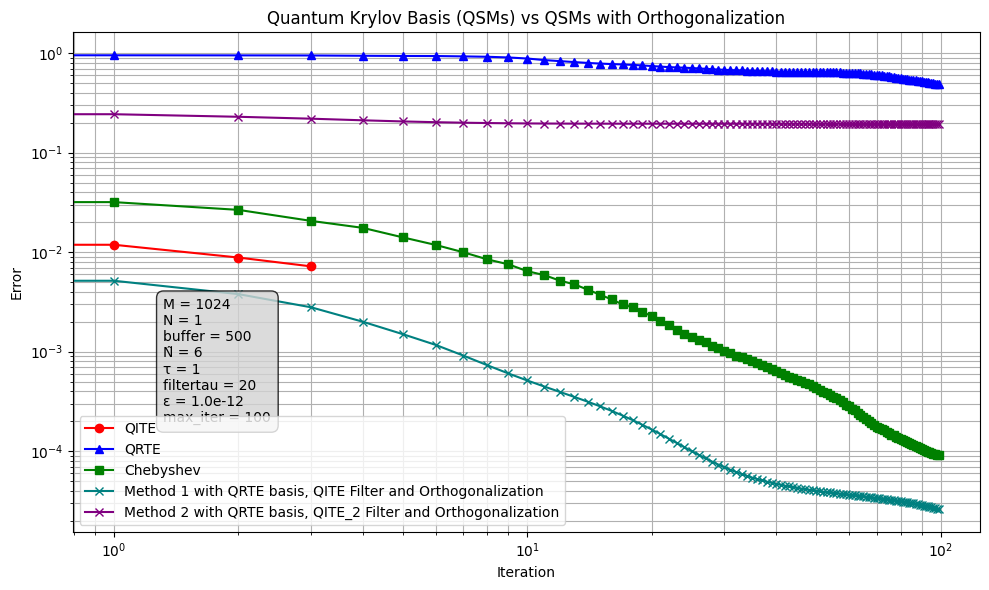

In [14]:
plt.figure(figsize=(10, 6))
plt.title('Quantum Krylov Basis (QSMs) vs QSMs with Orthogonalization')
plt.plot(np.arange(qite_itr), qite_abs_error[1:], marker='o', label='QITE', color='red')
# plt.plot(np.arange(qite_ortho_itr), qite_ortho_abs_error[1:], marker='^', label='QITE_w/ ortho', color='orange')
plt.plot(np.arange(qrte_itr), qrte_abs_error[1:], marker='^', label='QRTE', color='blue')
# plt.plot(np.arange(qrte_ortho_itr), qrte_ortho_abs_error[1:], marker='s', label='QRTE_w/ ortho', color='magenta')
plt.plot(np.arange(chebyshev_itr), chebyshev_abs_error[1:], marker='s', label='Chebyshev', color='green')
# plt.plot(np.arange(chebyshev_ortho_itr), chebyshev_ortho_abs_error[1:], marker='d', label='Chebyshev_w/ ortho', color='cyan')
plt.plot(np.arange(method1_itr), method1_abs_error[1:], marker='x', label='Method 1 with QRTE basis, QITE Filter and Orthogonalization', color='teal')
plt.plot(np.arange(method2_itr), method2_abs_error[1:], marker='x', label='Method 2 with QRTE basis, QITE_2 Filter and Orthogonalization', color='purple')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.grid(True, 'both', 'both')
plt.legend()
info_text = (
    f"M = {M}\n"
    f"N = {N}\n"
    f"buffer = {buffer}\n"
    f"Ñ = {Ntilde}\n"
    f"τ = {deltatau}\n"
    f"filtertau = {filtertau}\n"
    f"ε = {epsilon:.1e}\n"
    f"max_iter = {max_iter}"
)

# Adjust position (x=0.65, y=0.5) as needed
plt.text(0.1, 0.22, info_text, transform=plt.gca().transAxes,
         fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgrey', alpha=0.8))
plt.legend()
plt.tight_layout()
plt.show()